In [1]:
import torch
from agents.debn_ps import *
from environments.env_gridworld import *
from tqdm import tqdm 
from torchsummary import summary
from torch import tensor

import seaborn as sns
import matplotlib
%matplotlib inline 
import  matplotlib.pyplot as plt
from IPython.display import display, clear_output
sns.set()

In [ ]:
from qumcmc.classical_mcmc_routines import * 
from qumcmc.quantum_mcmc_routines_qulacs import *
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling
from qumcmc.basic_utils import plot_multiple_bargraphs
from agents.enhanced_samplng import *

### **TEST RUN on AGENT/ENVIRONMENT/DEBN modules**

#### EXPERIMENTS on ENVIRONMENT

In [2]:
envs = TaskEnvironment((10,10)) ##(10x10 rectangular gridworld)

In [3]:
envs.num_percepts_list

(10, 10)

In [4]:
print('pos i:', envs.position )
envs.step(1)
envs.step(3)
print('pos f:', envs.position )

pos i: [0 0]
pos f: [0 0]


In [6]:
trajectory = []
for _ in tqdm(range(1000)):
    envs.step(np.random.choice([0,1,2,3]))
    trajectory.append(envs.position)


100%|██████████| 1000/1000 [00:00<00:00, 5283.12it/s]


#### EXPERIMENTS on DEBN 

In [3]:
net = DEBN(8,4,dim_hidden_=[6])

In [4]:
param_dict = dict([(item[0], item[1].data) for item in net.named_parameters()])
    
    
param_dict

{'visible.weight': tensor([[-0.1620,  0.3121, -0.6726, -0.2420,  0.0477,  0.3930, -0.0823, -0.3382,
          -0.2296,  0.2128,  0.4605,  0.6603],
         [ 0.6891, -0.2066, -0.3498, -0.5563, -0.0212, -0.5517, -0.6056, -0.3580,
          -0.6711, -0.3341,  0.0233, -0.6707],
         [-0.2864, -0.4013,  0.5095, -0.6615,  0.2191, -0.4992, -0.1398,  0.5459,
          -0.2505,  0.5894,  0.3189, -0.0939],
         [ 0.6605, -0.3909, -0.6036, -0.2306,  0.4589, -0.6053,  0.1911,  0.6149,
           0.1215, -0.2988, -0.6429,  0.2827],
         [ 0.2654, -0.2589,  0.3745,  0.4002,  0.1431,  0.3468, -0.4047,  0.1543,
           0.5840, -0.5988, -0.4136,  0.4294],
         [-0.2987,  0.3288, -0.2378,  0.6464, -0.3056,  0.7022, -0.0679,  0.6428,
           0.3154, -0.2209,  0.4032,  0.4141]]),
 'visible.bias': tensor([-0.0557,  0.0146, -0.1459,  0.1421, -0.0193, -0.2491]),
 'b_input.weight': tensor([[ 0.0185, -0.0575, -0.1490,  0.0772, -0.1079,  0.1430,  0.0465,  0.2708,
          -0.1944, -0.267

In [82]:
np.append(param_dict['visible.bias'].numpy(), param_dict['b_input.weight'].numpy() )

array([-0.05051669, -0.26176426,  0.06592607, -0.02258434, -0.10423838,
       -0.27863848, -0.04080069,  0.24458791, -0.24395695, -0.10152031,
       -0.02794464, -0.2167844 , -0.14266838, -0.23284821,  0.07220743,
        0.24231963,  0.14297189, -0.09822213], dtype=float32)

<AxesSubplot:>

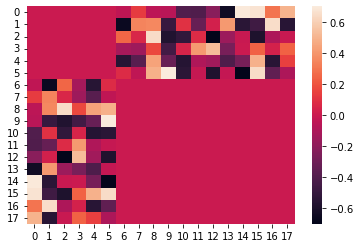

In [78]:
params = list(net.named_parameters())

a = param_dict['visible.weight'].numpy()
# a = a.transpose()

z0 = np.zeros((a.shape[0],a.shape[0]))
z1 = np.zeros((a.shape[1],a.shape[1]))

up = np.concatenate((z0, a), axis= 1)
down = np.concatenate( (a.transpose(), z1), axis= 1)

mat = np.concatenate((up,down), axis= 0)

sns.heatmap(mat)

#### New Definitions

In [3]:
def build_energy_model(net: DEBN):
    """ Works with only single hidden layer type RBMs """
    
    model_dim = net.visible.in_features + net.visible.out_features
    # named_params = list(net.named_parameters())
    param_dict = dict([(item[0], item[1].data) for item in net.named_parameters()])

    interactions = param_dict['visible.weight'].numpy()
    z0 = np.zeros((interactions.shape[0],interactions.shape[0])); z1 = np.zeros((interactions.shape[1],interactions.shape[1]))
    up = np.concatenate((z0, interactions), axis= 1); down = np.concatenate( (interactions.transpose(), z1), axis= 1)
    J = np.concatenate((up,down), axis= 0)

    biases = np.append(param_dict['visible.bias'].numpy(), param_dict['b_input.weight'].numpy() )

    ##checks
    assert model_dim == len(biases)
    assert model_dim == J.shape[0] 

    ##construct model
    model = IsingEnergyFunction(J, biases, "DEBN")

    return model
  

In [6]:
net_model = build_energy_model(agent.policy_net)

            MODEL : DEBN
Non-zero Interactions (J) : 60 / 136
Non-zero Bias (h) : 17 / 17
---------------------------------------------
Average Interaction Strength <|J|> :  0.1457030708874595
Average Bias Strength <|h|>:  0.13778977
alpha :  1.298398637410132
---------------------------------------------


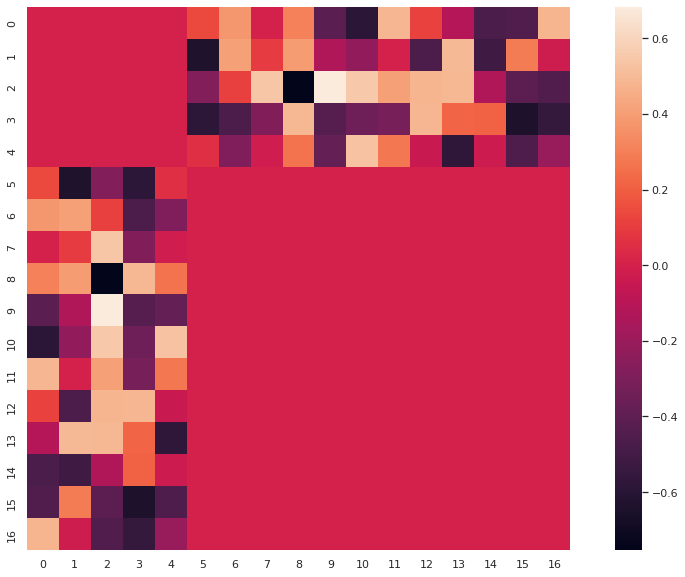

In [7]:
net_model.model_summary()

In [10]:
esm_net = Exact_Sampling(net_model)

Running Exact Sampling | beta :  1.0


running over all possible configurations: 100%|██████████| 131072/131072 [00:07<00:00, 17827.18it/s]


saving distribution to model ...


(tensor([[1., 0., 0., 0., 1., 0., 0., 0.]]), '10001000')

In [55]:
rsmp = RestrictedSampling(net_model, hidden_units_layer, action_size, percept_size_twoh, percept_to_str(percept))
clchn = rsmp.run_classical_mcmc(100);
cdct = clchn.get_accepted_dict(normalize= True)

current state:  MCMCState(hidden='10001', action='0010', state='10001000', accepted=True)


running MCMC steps ...: 100%|██████████| 100/100 [00:00<00:00, 13223.73it/s]

current state:  MCMCState(hidden='00011', action='1100', state='10001000', accepted=True)
current state:  MCMCState(hidden='11100', action='0011', state='10001000', accepted=True)
current state:  MCMCState(hidden='00011', action='1001', state='10001000', accepted=True)
current state:  MCMCState(hidden='11010', action='1110', state='10001000', accepted=True)
current state:  MCMCState(hidden='00000', action='0000', state='10001000', accepted=True)
current state:  MCMCState(hidden='01100', action='0000', state='10001000', accepted=True)
current state:  MCMCState(hidden='01001', action='0010', state='10001000', accepted=True)
current state:  MCMCState(hidden='10000', action='0101', state='10001000', accepted=True)
current state:  MCMCState(hidden='01000', action='0001', state='10001000', accepted=True)
current state:  MCMCState(hidden='01010', action='1101', state='10001000', accepted=True)
current state:  MCMCState(hidden='01000', action='0100', state='10001000', accepted=True)
current st

In [57]:
rsmp = RestrictedSampling(net_model, hidden_units_layer, action_size, percept_size_twoh, percept_to_str(percept))
qchn = rsmp.run_quantum_enhanced_mcmc(100, verbose=False)
qdct = qchn.get_accepted_dict(normalize=True)

runnning quantum MCMC steps . ..: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


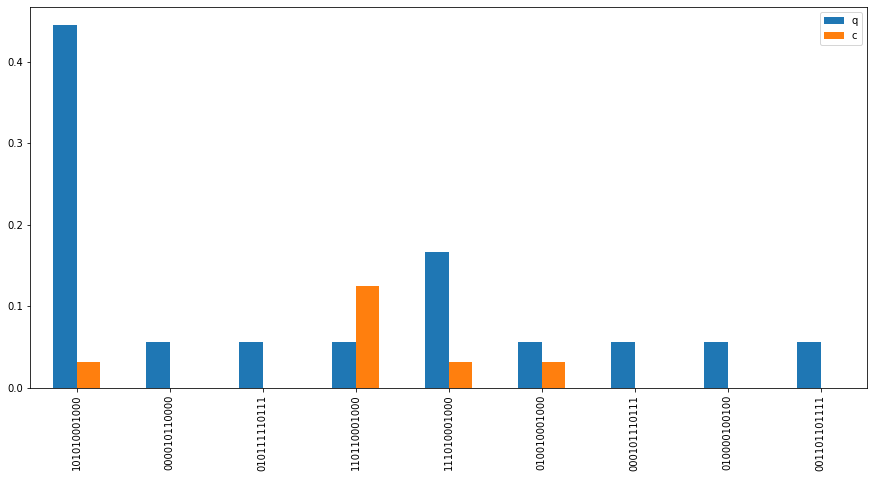

In [59]:
plot_multiple_bargraphs([dict(qdct), dict(cdct)], ['q', 'c'], [False, False], 15)

#### TRIAL RUNS

In [4]:
# INTERACTION PARAMETERS #
#------------------------#
EPISODES = 100  # number of episodes for each agent 2000
MAX_STEPS_PER_TRIAL = 50  # number of allowed timesteps before reset 20000

#agent parameters
AGENT_NUMBER = 1
DEVICE = 'cpu'
AGENT_NAME = 'ebm'

GAMMA = 0.99 # discount factor
hidden_layers = 1 # number of hidden layers
hidden_units_layer = 5 # number of hidden units
NUM_HIDDEN = [int(round(hidden_units_layer))]*hidden_layers # list of hidden unit numbers list
DROPOUT = [0.]*hidden_layers # dropout rate list
LEARNING_RATE = 0.001 # learning rate
CAPACITY = 500 # size of the memory
BATCH_SIZE = 100 # size of the training batch for experience replay
REPLAY_TIME = 50 # the time interval between each experience replay
TARGET_UPDATE = 100 # update interval for the target network
SAVE_MODEL = False #set to true to save state dict

BETA_i = 0.001 # initial beta parameter for schedule
BETA_f = 0.08 # final beta parameter for schedule
SCHEDULE = 'htan' # name of the schedule
if SCHEDULE == 'htan':
    beta = np.tanh(np.linspace(BETA_i, BETA_f, EPISODES)) # tanh schedule
elif SCHEDULE =='lin':
    beta = np.linspace(BETA_i, BETA_f, EPISODES) # linear scchedule

# ENVIRONMENT PARAMETERS
ENV_NAME = 'gridworld' # environment name
DIMENSIONS = [4,4] # 2D grid of size [10,10]
env = TaskEnvironment(DIMENSIONS) #generate environment

## 'percept_size' depends on the encdoing 
percept_size_oneh = DIMENSIONS[0]*DIMENSIONS[1] #size of the percept space 
percept_size_twoh = DIMENSIONS[0]+DIMENSIONS[1] #size of the percept space

action_size = 4 # size of the action space

#action encoding
all_actions = torch.empty(0)
for i in range(action_size):
    a = torch.zeros((1, 1, action_size))
    a = a.new_full((1, 1, action_size), 0.)
    a[0, 0, i] = 1.
    all_actions = torch.cat((all_actions, a))

#percept encoding
def to_two_hot(percept, dim):
    """
    Two-hot encodes the 2D percept of positions.
    """
    two_hot = np.zeros(dim[0]+dim[1]) ##added
    two_hot[percept[0]] = 1
    two_hot[dim[0]+percept[1]] = 1
    return two_hot


#percept encoding
def to_one_hot(percept, dim):
    """
    One-hot encodes the 2D percept of positions.
    """
    one_hot = np.zeros(dim[0]*dim[1]) ## multiplied
    
    one_hot[dim[0]*percept[0] + percept[1]] = 1
    
    return one_hot    

# DEFINE AGENT           #
#------------------------#
agent = DEBNAgent(percept_size_twoh, action_size, all_actions, dim_hidden=NUM_HIDDEN, dropout_rate=DROPOUT,
                    device = DEVICE, learning_rate=LEARNING_RATE, capacity=CAPACITY, batch_size=BATCH_SIZE, replay_time=REPLAY_TIME,
                    target_update = TARGET_UPDATE, gamma = GAMMA, train_output_weights = False)

EPISODES = 100
MAX_STEPS_PER_TRIAL = 100
verbose = False
coords = []
# RUN TRAINING STEPS     #
#------------------------#
timesteps = []
for e in tqdm(range(EPISODES), desc= 'running episodes'):
    counter = 0
    #reset the environment
    percept = env.reset()
    coords.append(percept) ## coords stroing 
    # percept = to_one_hot(percept,DIMENSIONS)
    # percept = np.reshape(percept, [1, percept_size_oneh])
    percept = to_two_hot(percept,DIMENSIONS)
    percept = np.reshape(percept, [1, percept_size_twoh])
    percept = torch.Tensor(percept)
    reward = 0.
    done = False
    # for t in tqdm(range(1, MAX_STEPS_PER_TRIAL + 1), desc= 'runnnig episode . .. '+str(e) ):
    for t in range(1, MAX_STEPS_PER_TRIAL + 1):
        
        action = agent.deliberate_and_learn(percept, None, reward, GAMMA, done, beta[e])
        action = (action[0] == 1).nonzero().item()
        percept, reward, done, _ = env.step(action)
        coords.append(percept) ## coords storing 

        if verbose :  print('action : '+str( action) + ' percept : ' + str(percept) + ' reward : '+ str( reward))
        # percept = to_one_hot(percept, DIMENSIONS)
        # percept = np.reshape(percept, [1, percept_size_oneh])
        percept = to_two_hot(percept,DIMENSIONS)
        percept = np.reshape(percept, [1, percept_size_twoh])
        percept = torch.Tensor(percept)
        
        if t==MAX_STEPS_PER_TRIAL:
            reward = -1
            done = True
        if done:
            agent.deliberate_and_learn(percept, None, reward, GAMMA, done, beta[e])
            timesteps.append(t)
            break

    if e%100 == 0:
        if verbose : print("Average last 100 scores (timesteps per episode) the agent achieved at " + str(e) + ": ", np.mean(timesteps[-100:]))
        # save data to file

## get trajectory plotting data ##
xs = []; ys = []
for coord in coords: 
    xs.append(coord[0])
    ys.append(coord[1])

running episodes: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


In [12]:
agent._choose_action(percept, 1)

tensor([[0., 0., 1., 0.]])

In [26]:
## visualise trajectory dynamically ## not very efficeint
plt.figure(figsize=(12,12))
for coord in tqdm(coords) :
    plt.plot(coord[0], coord[1], 'o', 'r')
    clear_output(wait= True)
    plt.show()
# plt.scatter(xs, ys )


  1%|          | 61/5250 [00:16<23:26,  3.69it/s]


KeyboardInterrupt: 

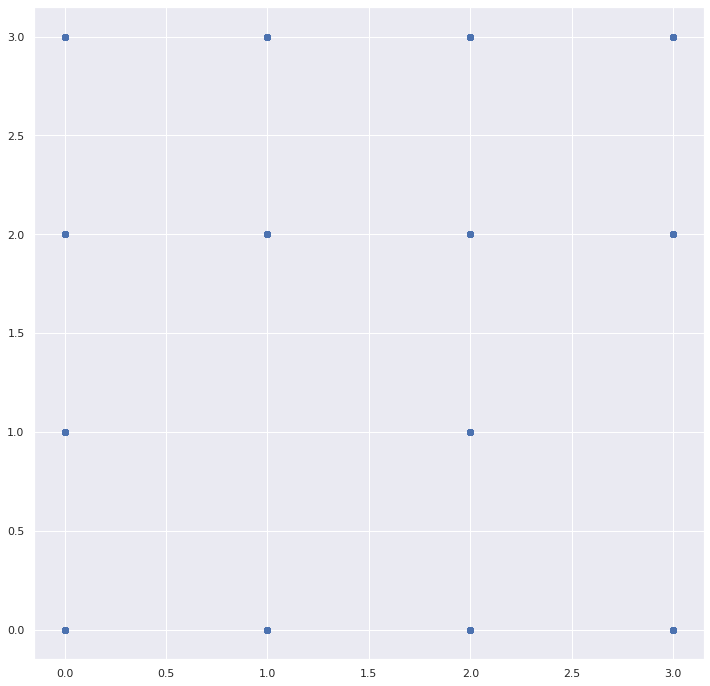

In [25]:
## visualise spots visited  ##
plt.figure(figsize=(12,12))
# for coord in tqdm(coords) :
#     plt.plot(xs, ys, '-o', 'r')
plt.scatter(xs, ys )
plt.show()